In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'svg'

In [2]:
movie_df = pd.read_pickle("main_movie_df.pkl")

In [3]:
movie_df

,movie_title,runtime,genres,rating,domestic_box_office,international_box_office,domestic_opening_weekend,budget,release_date,criticscore,...,actors,genres_1,months,G,PG,PG-13,Adventure,Comedy,Drama,directors_1
0,Star Wars: Episode VII - The Force Awakens,138,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,936.662225,1131.793436,247.966675,245.000000,2015-12-18,80,...,"['Daisy Ridley', 'John Boyega', 'Oscar Isaac']",'Adventure',12,0,0,1,1,0,0,1
1,Avatar,162,"'Adventure', 'Adventure', 'Fantasy', 'Sci-Fi'",PG-13,760.507625,2083.806217,77.025481,237.000000,2009-12-18,83,...,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",'Adventure',12,0,0,1,1,0,0,1
2,Black Panther,134,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,700.426566,647.171407,202.003951,700.059566,2018-02-16,88,...,"['Chadwick Boseman', 'Michael B. Jordan', ""Lup...",'Adventure',2,0,0,1,1,0,0,1
3,Jurassic World,124,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,652.385625,1018.130819,208.806270,150.000000,2015-06-12,59,...,"['Chris Pratt', 'Bryce Dallas Howard', 'Ty Sim...",'Adventure',6,0,0,1,1,0,0,0
4,The Avengers,143,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,623.357910,895.457605,207.438708,220.000000,2012-05-04,69,...,"['Robert Downey Jr.', 'Chris Evans', 'Scarlett...",'Adventure',5,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,Grudge Match,113,"'Comedy', 'Drama', 'Sport'",PG-13,29.807260,15.100000,7.021993,40.000000,2013-12-25,35,...,"['Robert De Niro', 'Sylvester Stallone', 'Kim ...",'Comedy',12,0,0,1,0,1,0,1
1539,The Hate U Give,133,"'Crime', 'Drama'",PG-13,29.719483,5.214526,0.512035,23.000000,2018-10-19,81,...,"['Amandla Stenberg', 'Regina Hall', 'Russell H...",Others,10,0,0,1,0,0,0,0
1540,When the Bough Breaks,107,"'Drama', 'Thriller'",PG-13,29.747603,0.910784,14.202323,10.000000,2016-09-09,28,...,"['Morris Chestnut', 'Regina Hall', 'Romany Mal...",'Drama',9,0,0,1,0,0,1,0
1541,Did You Hear About the Morgans?,103,"'Comedy', 'Drama', 'Romance'",PG-13,29.580087,55.700163,6.616571,58.000000,2009-12-18,27,...,"['Hugh Grant', 'Sarah Jessica Parker', 'Sam El...",'Comedy',12,0,0,1,0,1,0,0


In [4]:
from sklearn.model_selection import KFold

features, target = [['runtime', 'budget', 'criticscore', 'months', 'Adventure'], 'international_box_office']
X, y = movie_df[features], movie_df[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

X, y = np.array(X), np.array(y)

In [5]:
X.shape

(1215, 5)

In [6]:
X_test.shape

(304, 5)

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

train_linear_r2s, train_ridge_r2s, train_poly_r2s, train_lasso_r2s = [], [], [], []
val_linear_r2s, val_ridge_r2s, val_poly_r2s, val_lasso_r2s = [], [], [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    lm = LinearRegression()
    lm_ridge = Ridge(alpha=1)
    lm_lasso = Lasso(alpha=0.005)
    lm_poly = LinearRegression()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    #linear regression
    lm.fit(X_train, y_train)
    preds = lm.predict(X_train) 
    linear_train_rmse = mean_squared_error(y_train, preds, squared=False)
    linear_train_mae = mean_absolute_error(y_train, preds)
    
    preds = lm.predict(X_val) 
    linear_val_rmse = mean_squared_error(y_val, preds, squared=False)
    linear_val_mae = mean_absolute_error(y_val, preds)
    
    train_linear_r2s.append(lm.score(X_train, y_train))
    val_linear_r2s.append(lm.score(X_val, y_val))

    #polynomial regression
    lm_poly.fit(X_train_poly, y_train)
    preds = lm_poly.predict(X_train_poly) 
    poly_train_rmse = mean_squared_error(y_train, preds, squared=False)
    poly_train_mae = mean_absolute_error(y_train, preds)
    
    preds = lm_poly.predict(X_val_poly) 
    poly_val_rmse = mean_squared_error(y_val, preds, squared=False)
    poly_val_mae = mean_absolute_error(y_val, preds)
    
    train_poly_r2s.append(lm_poly.score(X_train_poly, y_train))
    val_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
 
    #ridge regression
    lm_ridge.fit(X_train_scaled, y_train)
    preds = lm_ridge.predict(X_train_scaled) 
    ridge_train_rmse = mean_squared_error(y_train, preds, squared=False)
    ridge_train_mae = mean_absolute_error(y_train, preds)
    
    preds = lm_ridge.predict(X_val_scaled) 
    ridge_val_rmse = mean_squared_error(y_val, preds, squared=False)
    ridge_val_mae = mean_absolute_error(y_val, preds)
    
    train_ridge_r2s.append(lm_ridge.score(X_train_scaled, y_train))
    val_ridge_r2s.append(lm_ridge.score(X_val_scaled, y_val))
    
    #lasso regression
    lm_lasso.fit(X_train_scaled, y_train)
    preds = lm_lasso.predict(X_train_scaled) 
    lasso_train_rmse = mean_squared_error(y_train, preds, squared=False)
    lasso_train_mae = mean_absolute_error(y_train, preds)
    
    preds = lm_lasso.predict(X_val_scaled) 
    lasso_val_rmse = mean_squared_error(y_val, preds, squared=False)
    lasso_val_mae = mean_absolute_error(y_val, preds)
    
    train_lasso_r2s.append(lm_lasso.score(X_train_scaled, y_train))
    val_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
        

print('Simple regression training scores: ', train_linear_r2s)
print('Simple regression validation scores: ', val_linear_r2s, '\n')

print('Polynomial regression training scores: ', train_poly_r2s)
print('Polynomial regression validation scores: ', val_poly_r2s, '\n')

print('Lasso training scores: ', train_lasso_r2s)
print('Lasso validation scores: ', val_lasso_r2s, '\n')

print('Ridge training scores: ', train_ridge_r2s)
print('Ridge validation scores: ', val_ridge_r2s, '\n')

print(f'Simple regression training mean cv r^2: {np.mean(train_linear_r2s):.3f} +- {np.std(train_linear_r2s):.3f}')
print("Simple regression training rmse:", linear_train_rmse)
print("Simple regression training mae:",linear_train_mae, '\n')

print(f'Simple regression validation mean cv r^2: {np.mean(val_linear_r2s):.3f} +- {np.std(val_linear_r2s):.3f}')
print("Simple regression validation rmse:",linear_val_rmse)
print("Simple regression validation mae:",linear_val_mae, '\n')

print(f'Poly regression training mean cv r^2: {np.mean(train_poly_r2s):.3f} +- {np.std(train_poly_r2s):.3f}')
print("Poly regression training rmse:", poly_train_rmse)
print("Poly regression training mae:",poly_train_mae, '\n')

print(f'Poly regression validation mean cv r^2: {np.mean(val_poly_r2s):.3f} +- {np.std(val_poly_r2s):.3f}')
print("Poly regression validation rmse:",poly_val_rmse)
print("Poly regression validation mae:",poly_val_mae, '\n')

print(f'Lasso training mean cv r^2: {np.mean(train_lasso_r2s):.3f} +- {np.std(train_lasso_r2s):.3f}')
print("Lasso regression training rmse:", lasso_train_rmse)
print("Lasso regression training mae:",lasso_train_mae, '\n')

print(f'Lasso validation mean cv r^2: {np.mean(val_lasso_r2s):.3f} +- {np.std(val_lasso_r2s):.3f}')
print("Lasso regression validation rmse:",lasso_val_rmse)
print("Lasso regression validation mae:",lasso_val_mae, '\n')

print(f'Ridge training mean cv r^2: {np.mean(train_ridge_r2s):.3f} +- {np.std(train_ridge_r2s):.3f}')
print("Ridge regression training rmse:",ridge_train_rmse)
print("Ridge regression training mae:",ridge_train_mae, '\n')

print(f'Ridge validation mean cv r^2: {np.mean(val_ridge_r2s):.3f} +- {np.std(val_ridge_r2s):.3f}')
print("Ridge regression validation rmse:",ridge_val_rmse)
print("Ridge regression validation mae:",ridge_val_mae, '\n')

Simple regression training scores:  [0.5060544079949332, 0.5204635979751285, 0.5321399980078174, 0.5148648143305825, 0.5102102402385805]
Simple regression validation scores:  [0.5229858159381346, 0.4840876005489735, 0.33657759176736723, 0.5036264036702507, 0.5240532181485613] 

Polynomial regression training scores:  [0.5568679654512438, 0.602201957575891, 0.5875169159380719, 0.5845537340593401, 0.5837733021696785]
Polynomial regression validation scores:  [0.611505737978947, 0.4815123284267814, -0.010670420422684401, 0.5417535756187097, 0.5405827751189106] 

Lasso training scores:  [0.5060544043826365, 0.5204635947627179, 0.5321399949756638, 0.5148648113715013, 0.5102102371663491]
Lasso validation scores:  [0.5229725744432552, 0.4840881565381264, 0.33659160617408457, 0.5036306567507247, 0.5240583337726608] 

Ridge training scores:  [0.5060539699442819, 0.5204631681433098, 0.5321392886926062, 0.5148643596815736, 0.5102098041332379]
Ridge validation scores:  [0.5228131341515232, 0.48395

In [8]:
lm = LinearRegression()
lm.fit(X,y)
preds = lm.predict(X_test)

linear_test_rmse = mean_squared_error(y_test, preds, squared=False)
linear_test_mae = mean_absolute_error(y_test, preds)

linear_test_r2 = lm.score(X_test, y_test)

print(linear_test_rmse)
print(linear_test_mae)
print(linear_test_r2)

115.29823973873027
76.03596078980675
0.5346366173264192


In [9]:
lm_poly = LinearRegression()
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)

lm_poly.fit(X_poly, y)
    
poly_preds = lm_poly.predict(X_test_poly)

poly_test_rmse = mean_squared_error(y_test, poly_preds, squared=False)
poly_test_mae = mean_absolute_error(y_test, poly_preds)
poly_test_r2 = lm_poly.score(X_test_poly, y_test)

print(poly_test_rmse)
print(poly_test_mae)
print(poly_test_r2)
#list(zip(poly.get_feature_names(['runtime', 'budget', 'criticscore', 'months', 'Adventure']),lm_poly.coef_))

112.34558146422091
69.33752417049273
0.558166291188888


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_ridge = Ridge(alpha=1)
lm_ridge.fit(X_scaled,y)

preds = lm_ridge.predict(X_test_scaled)

ridge_test_rmse = mean_squared_error(y_test, preds, squared=False)
ridge_test_mae = mean_absolute_error(y_test, preds)

ridge_test_r2 = lm_ridge.score(X_test_scaled, y_test)

print(ridge_test_rmse)
print(ridge_test_mae)
print(ridge_test_r2)


115.31171145808453
76.03514439439466
0.5345278626540142


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

lm_lasso = Lasso(alpha=0.005)
lm_lasso.fit(X_scaled, y)

lasso_preds = lm_lasso.predict(X_test_scaled)

lasso_test_r2 = lm_lasso.score(X_test_scaled, y_test)

lasso_test_rmse = mean_squared_error(y_test, lasso_preds, squared=False)
lasso_test_mae = mean_absolute_error(y_test, lasso_preds)

print(lasso_test_rmse)
print(lasso_test_mae)
print(lasso_test_r2)
print(lm_lasso.coef_)

114.76522085910452
75.84526758994826
0.5389293821238741
[17.92224626 95.98789705 17.97127687  7.65594686 11.10931357]


In [12]:
d = {'model_type': ['simple linear', 'polynomial', 'ridge', 'LASSO'],\
     'r-squared': [linear_test_r2, poly_test_r2, ridge_test_r2, lasso_test_r2],\
     'rmse': [linear_test_rmse, poly_test_rmse, ridge_test_rmse, lasso_test_rmse],\
     'mae': [linear_test_mae, poly_test_mae, ridge_test_mae, lasso_test_mae]}
df = pd.DataFrame(data=d)
df = df.style.set_caption('cv/test model cases')
df

,model_type,r-squared,rmse,mae
0,simple linear,0.534637,115.298240,76.035961
1,polynomial,0.558166,112.345581,69.337524
2,ridge,0.534528,115.311711,76.035144
3,LASSO,0.538929,114.765221,75.845268


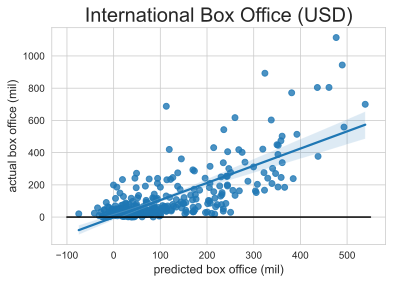

<Figure size 864x864 with 0 Axes>

In [16]:
sns.set_style('whitegrid') 
sns.regplot(data = movie_df, x=lasso_preds, y=y_test)

plt.plot([-100, 550], [0,0], color="black")
plt.title('International Box Office (USD)', fontsize = 20)
plt.ylabel('actual box office (mil)', fontsize=12)
plt.xlabel('predicted box office (mil)', fontsize=12)

plt.figure(figsize=(12,12))
plt.savefig('testing.png');